# Analysis

## 1. Load json file

In [1]:
import pandas as pd 
import numpy as np
import json

In [2]:
def loadDetailsJson(file_location):
    class_map = json.load(open(file_location+'class_maps.json'))
    df = pd.DataFrame.from_records(list(map(json.loads, open(file_location+'details.log').readlines())))
    df = df.drop('render_args', axis=1).join(pd.DataFrame(df.render_args.values.tolist()))
    df['prediction'] = df['prediction'].apply(lambda x: class_map[x[0]])
    df['is_correct'] = (df['is_correct'] == 'True') 
    return df
df = loadDetailsJson(input("Input location to details.log and class_maps.json:")) #input: ../results/
df.head()

,is_correct,loss,prediction,id,environment,model,output_type,OrbitingCameraControl.theta,SunControl.elevation,HazeControl.haze_fac,...,SunControl.intensity,SunControl.rotation,SunControl.altitude,SunControl.air,SunControl.dust,SunControl.ozone,SunControl.background_strength,HazeControl.haze_start,HazeControl.haze_depth,HazeControl.haze_falloff
0,False,1.3123251,cup,75d34d25-05ea-4a3a-a961-8a83a63e2a85,studioX_Stage.blend,025_mug.blend,classes,-1.57,0.0,0.0,...,1.0,0.0,1.0,3.0,1.0,1.0,0.1,0.5,10.0,QUADRATIC
1,False,2.7381895,"dining table, board",ac5e8227-8303-4e67-ad43-ca964edb3353,studioX_Stage.blend,025_mug.blend,classes,-1.57,0.0,0.0,...,1.0,0.0,1.0,3.0,1.0,1.0,0.1,0.5,10.0,QUADRATIC
2,False,5.9922523,"rocking chair, rocker",6d28bbf8-9a90-4f12-a868-201c2f64ce96,studioX_Stage.blend,025_mug.blend,classes,-1.57,0.0,0.0,...,1.0,0.0,1.0,3.0,1.0,1.0,0.1,0.5,10.0,QUADRATIC
3,False,3.739277,cup,beb37c9f-0494-43f4-b2df-97b5d6e0788c,studioX_Stage.blend,025_mug.blend,classes,-1.57,0.0,0.2,...,1.0,0.0,1.0,3.0,1.0,1.0,0.1,0.5,10.0,QUADRATIC
4,False,4.818928,"dining table, board",93b7e319-e4d7-408c-9e2e-d97214dec47d,studioX_Stage.blend,025_mug.blend,classes,-1.57,0.0,0.2,...,1.0,0.0,1.0,3.0,1.0,1.0,0.1,0.5,10.0,QUADRATIC


## 2. Detect which variables have varied

In [4]:
def outputVaryingVariables(df):
    varying_variables = []
    #ignore columns 0-3 ('is_correct', 'loss', 'prediction', 'id')
    for colname in df.columns[4:]:
        if (df[colname].dtype == "object"): # if it is not numeric
            if (df[colname].nunique() > 1):
                varying_variables.append(colname)
        else: # if it is numeric
            if (df[colname].var() > 0.0001): 
                varying_variables.append(colname)
    return varying_variables
outputVaryingVariables(df)

['OrbitingCameraControl.theta',
 'SunControl.elevation',
 'HazeControl.haze_fac',
 'RainControl.n_layers_of_rain']

## 3. Accuracy of different settings within a variable

In [44]:
def variableAccuracies(df):
    colnames = outputVaryingVariables(df)
    variables = {}
    for i, colname in enumerate(colnames):
        variables[colname] = df.groupby(colname).agg(accuracy=('is_correct', 'mean'),
                              most_frequent_prediction=('prediction', lambda x: x.mode()))
        variables[colname].sort_values(['accuracy'],ascending=True)
    return variables
variables = variableAccuracies(df)
variables['RainControl.n_layers_of_rain']

,accuracy,most_frequent_prediction
RainControl.n_layers_of_rain,,
0,0.074074,"bucket, pail"
1,0.111111,"[dining table, board, mosquito net, theater cu..."
3,0.074074,mosquito net


## 4. Which variable affects accuracy the most

In [10]:
def varianceOfVariableAccuracies(df):
    colnames = outputVaryingVariables(df)
    variances = {}
    for i, colname in enumerate(colnames):
        variances[colname] = [float(df.groupby(colname).agg(accuracy=('is_correct', 'mean')).var())]
    return pd.DataFrame(variances).transpose().rename({0: 'Accuracy Variance'}, axis=1).sort_values(['Accuracy Variance'],ascending=False)
varianceOfVariableAccuracies(df)

,Accuracy Variance
HazeControl.haze_fac,0.008688
SunControl.elevation,0.007316
OrbitingCameraControl.theta,0.005944
RainControl.n_layers_of_rain,0.000457


## 5. Which setting for each variable has the lowest accuracy

In [52]:
def lowestAccuracyPerVariable(df):
    colnames = outputVaryingVariables(df)
    accuracy_dict = variableAccuracies(df)
    lowestAccuracies = {}
    for i, colname in enumerate(colnames):
        lowestAccuracies[colname] = [accuracy_dict[colname]["accuracy"].idxmin(), accuracy_dict[colname]["accuracy"].min()]
    return pd.DataFrame(lowestAccuracies).transpose().rename({0: 'lowest_setting', 1:'lowest_accuracy'}, axis=1).sort_index()
lowestAccuracyPerVariable(df)

,lowest_setting,lowest_accuracy
HazeControl.haze_fac,0.4,0.000000
OrbitingCameraControl.theta,0.0,0.000000
RainControl.n_layers_of_rain,0.0,0.074074
SunControl.elevation,0.0,0.037037


## 6. Filter images with settings

/home/coffeemix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


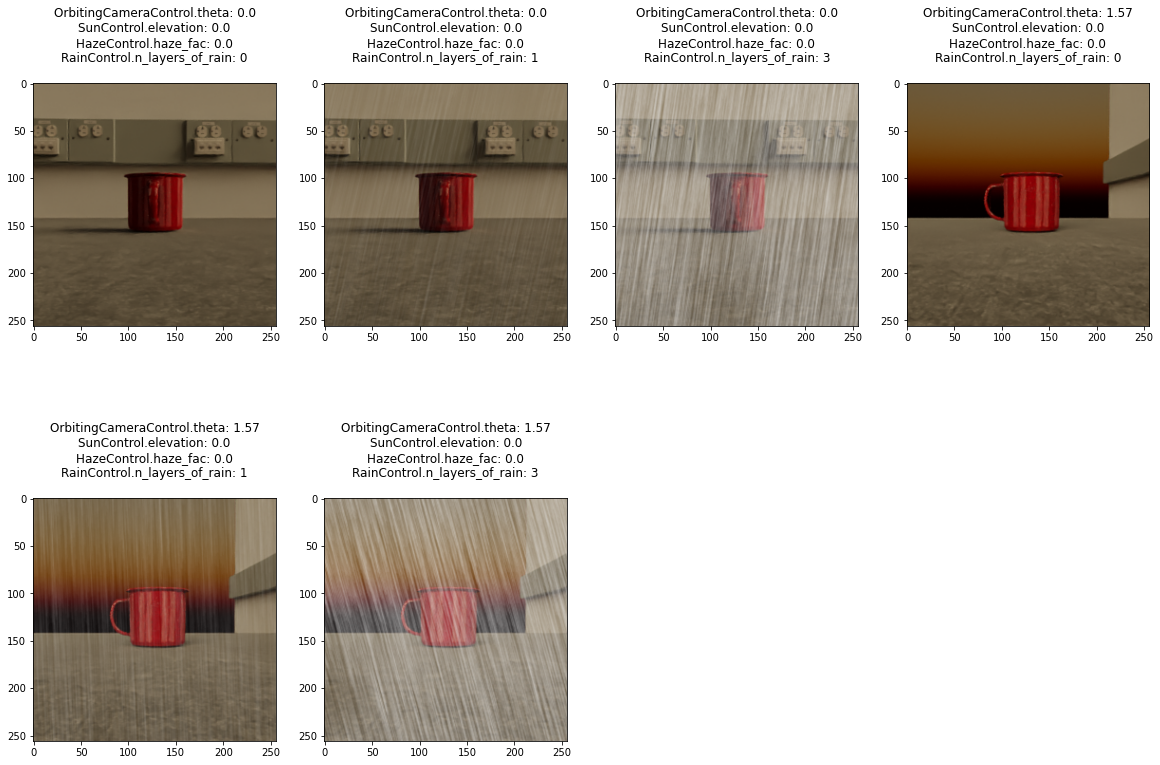

In [217]:
filter_input = { #inclusive of edges
    'HazeControl.haze_fac' : 0,
    'OrbitingCameraControl.theta': (0, 1.57),
    'RainControl.n_layers_of_rain': (0, 3),
    'SunControl.elevation': 0
}
def filterImageIds(df, filter_input):
    filtered_df = df.copy()
    for key, value in filter_input.items():
        if (type(value) is tuple):
            filtered_df = filtered_df.loc[(filtered_df[key]<=value[1]) & (filtered_df[key]>=value[0])]
        else:
            filtered_df = filtered_df.loc[filtered_df[key]==value]
    return filtered_df['id'].tolist()
def dictionaryToString(dict):
    returnString = ""
    for key, value in dict.items():
        returnString += str(key)+": "+ str(value)+"\n"
    return returnString
def getFilteredImages(df, filter_input, image_location):
    from math import ceil
    import matplotlib.pyplot as plt
    from matplotlib.image import imread
    image_ids = filterImageIds(df, filter_input)
    if (len(image_ids)<=0):
        print("There are no images.")
    columns = 4
    displayed_values = outputVaryingVariables(df)
    plt.figure(figsize=(20,ceil(len(image_ids)/columns)*(5+len(displayed_values)/2)))
    for i, image_id in enumerate(image_ids):
        image_filename = image_location + image_id + "_rgb.png"
        plt.subplot(len(image_ids) / columns + 1, columns, i + 1)
        plt.title(dictionaryToString(df[df['id']==image_id][displayed_values].to_dict('records')[0]))
        plt.imshow(imread(image_filename))
    plt.show() # or display.display(plt.gcf()) if you prefer
getFilteredImages(df, filter_input, "../results/images/")

In [363]:
class AnalysisModule:
    """Module for easy analysis of details.log json file and rgb images"""

    def __init__(self, file_location):
        import pandas as pd 
        import numpy as np
        import json

        self.file_location = file_location
        self.image_location = file_location + "images/"
        self.df = self._loadDetailsJson(file_location)
        self.varyingVariables = self._outputVaryingVariables()

    def _loadDetailsJson(self, file_location):
        """load json detail.log"""
        class_map = json.load(open(file_location+'class_maps.json'))
        df = pd.DataFrame.from_records(list(map(json.loads, open(file_location+'details.log').readlines())))
        df = df.drop('render_args', axis=1).join(pd.DataFrame(df.render_args.values.tolist()))
        df['prediction'] = df['prediction'].apply(lambda x: class_map[x[0]])
        df['is_correct'] = (df['is_correct'] == 'True') 
        return df
    
    def _outputVaryingVariables(self):
        """Get list of dependent variables"""
        varying_variables = []
        #ignore columns 0-3 ('is_correct', 'loss', 'prediction', 'id')
        for colname in self.df.columns[4:]:
            if (self.df[colname].dtype == "object"): # if it is not numeric
                if (self.df[colname].nunique() > 1):
                    varying_variables.append(colname)
            else: # if it is numeric
                if (self.df[colname].var() > 0.0001): 
                    varying_variables.append(colname)
        return varying_variables

    def variableSettingAccuracies(self, variable_name):
        """Accuracy on one variable, across different values"""
        if (variable_name in self.varyingVariables):
            return self.df.groupby(variable_name).agg(
                accuracy=('is_correct', 'mean'),
                most_frequent_prediction=('prediction', lambda x: x.mode())).sort_values(['accuracy'],ascending=True)
        else:
            print("Variable name either does not exist in the dataframe or remains constant through the experiment")
            print("Valid Variable Entries: "+ str(self.varyingVariables))
            print("To get overall accuracy use .overallAccuracy()")

    def overallAccuracy(self):
        """Accuracy across all variables"""
        print("Overall Accuracy: "+str(self.df['is_correct'].mean()))

    def varianceOfVariableAccuracies(self):
        """Which variables affects accuracy the most (changing of settings cause drastic changes in accuracy)"""
        variances = {}
        for i, colname in enumerate(self.varyingVariables):
            variances[colname] = [float(self.df.groupby(colname).agg(accuracy=('is_correct', 'mean')).var())]
        return pd.DataFrame(variances).transpose().rename({0: 'Accuracy Variance'}, axis=1).sort_values(['Accuracy Variance'],ascending=False)

    def lowestAccuracyPerVariable(self):
        """Which setting in each variable yield the lowest accuracy?"""
        lowestAccuracies = {}
        for i, colname in enumerate(self.varyingVariables):
            variableSettingAccuracies = self.variableSettingAccuracies(colname)
            lowestAccuracies[colname] = [variableSettingAccuracies["accuracy"].idxmin(), 
                                        variableSettingAccuracies["accuracy"].min()]
        return pd.DataFrame(lowestAccuracies).transpose().rename({0: 'lowest_setting', 
                                                                    1:'lowest_accuracy'}, axis=1).sort_index()
    
    def _filterImageIds(self, filter_input):
        """
        Get list of ids of images that pass through the filters

        Filter_input should be in this format (inclusive of edges):

            filter_input = { 
                'HazeControl.haze_fac' : 0,
                'OrbitingCameraControl.theta': (0, 1.57),
                'RainControl.n_layers_of_rain': (0, 3),
                'SunControl.elevation': 0
            }
            
        """
        filtered_df = self.df.copy()
        for key, value in filter_input.items():
            if (type(value) is tuple):
                filtered_df = filtered_df.loc[(filtered_df[key]<=value[1]) & (filtered_df[key]>=value[0])]
            else:
                filtered_df = filtered_df.loc[filtered_df[key]==value]
        return filtered_df['id'].tolist()

    def _getImageLabel(self, image_id, displayed_values):
        """Get label of an image"""
        dictionaryToDisplay = self.df[self.df['id']==image_id][displayed_values].to_dict('records')[0]
        label = ""
        for key, value in dictionaryToDisplay.items():
            label += str(key)+": "+ str(value)+"\n"
        return label
    
    def _getImageCorrect(self, image_id):
        """Find out if image was correctly predicted by the model."""
        return self.df[self.df["id"]==image_id]['is_correct'].bool()

    def getFilteredImages(self, filter_input, columns=4, displayed_values=[]):
        """Display Filtered Images"""
        from math import ceil
        import matplotlib.pyplot as plt
        from matplotlib.image import imread

        if (not (all(elem in self.df.columns for elem in displayed_values))):
            print("Not all columns in display_values are in the dataframe")
            return
        elif (len(displayed_values)==0): #if no values entered for displayed_values
            displayed_values=self.varyingVariables

        # Get number of rows
        image_ids = self._filterImageIds(filter_input)
        num_images = len(image_ids)
        rows = ceil(num_images/columns)

        #if there are no images
        if (len(image_ids)<=0):
            print("There are no images.")
            return

        #if there are images

        #Get figure height
        figure_width = 20
        size_of_each_image = figure_width/columns
        size_of_each_line_in_label = 0.5
        number_of_displayed_values = len(displayed_values)
        size_of_image_label = size_of_each_image + size_of_each_line_in_label*number_of_displayed_values 
        figure_height = rows * size_of_image_label

        #plot images
        plt.figure(figsize=(figure_width, figure_height))
        for i, image_id in enumerate(image_ids):
            image_filename = self.image_location + image_id + "_rgb.png"
            ax = plt.subplot(rows, columns, i + 1)
            plt.title(self._getImageLabel(image_id, displayed_values))
            color = "green" if self._getImageCorrect(image_id) else "red"
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(7)
            plt.imshow(imread(image_filename))
        plt.show()

In [364]:
analysis = AnalysisModule("../results/")


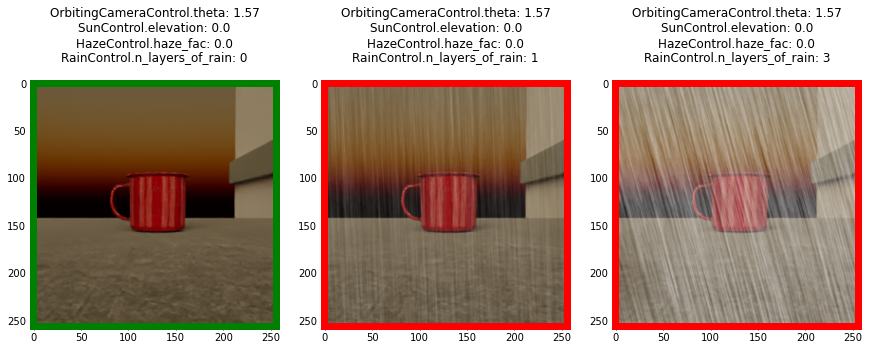

In [366]:
analysis.getFilteredImages(
    filter_input = { #inclusive of edges
        'HazeControl.haze_fac' : 0,
        'OrbitingCameraControl.theta': 1.57,
        'RainControl.n_layers_of_rain': (0, 3),
        'SunControl.elevation': 0
    }
)